# Linear Classification with Softmax Loss

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [8]:
import time
import random
import numpy as np
from dl4cv.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).
Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [9]:
from dl4cv.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

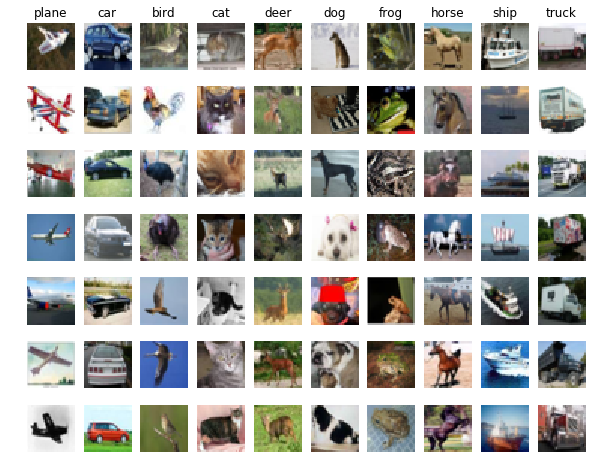

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]


# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [12]:
#Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64297917  135.92841667  132.4100625   130.0744375   135.3130625
  131.70479167  131.0373125   136.18741667  132.48804167  131.65420833]


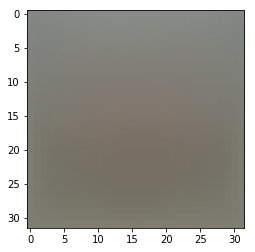

In [13]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [14]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [15]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

Your code for this section will all be written inside `dl4cv/classifiers/softmax.py`. 
You will implement the gradient of the loss function with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement the naive softmax loss function with nested loops.
Open the file `dl4cv/classifiers/softmax.py` and implement the softmax_loss_naive function.
Running this method might take a while...

In [16]:
from dl4cv.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.375423
sanity check: 2.302585


### Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** *Fill this in*


In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from dl4cv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 0.334247 analytic: 0.334247, relative error: 2.005900e-07
numerical: -0.482354 analytic: -0.482354, relative error: 8.119382e-09
numerical: 1.145573 analytic: 1.145573, relative error: 8.149138e-08
numerical: 6.585341 analytic: 6.585341, relative error: 1.069868e-08
numerical: -1.490331 analytic: -1.490331, relative error: 2.134418e-09
numerical: -2.153338 analytic: -2.153338, relative error: 3.688068e-08


### Vectorized Implementation
Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized.
The two versions should compute the same results, but the vectorized version should be much faster.

In [18]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from dl4cv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.375423e+00 computed in 0.515946s
vectorized loss: 2.375423e+00 computed in 0.054318s
Loss difference: 0.000000
Gradient difference: 0.000000


### Inline Question 2:
When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?

(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)

**Your answer:** *Fill this in*


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from dl4cv.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=3.4e-6, reg=4.7e2,
                      num_iters=500,batch_size=48000, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 500: loss 12.968009
iteration 100 / 500: loss 1.941210
iteration 200 / 500: loss 1.746139
iteration 300 / 500: loss 1.739991
iteration 400 / 500: loss 1.740256
That took 529.133594s


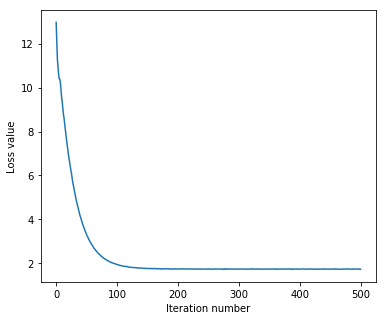

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred),)
y_val_pred = softmax.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred),)

training accuracy: 0.428938
validation accuracy: 0.418000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength, learning rate and possibly batch size). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [ ]:
from dl4cv.classifiers import Softmax

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = Softmax()
learning_rates = [2.5e-6, 4e-6]
regularization_strengths = [4.5e2,1e3]
batch_size = [200,600]
steps = 14
l_r = np.linspace(learning_rates[0],learning_rates[1],steps,endpoint = True)
r_s = np.logspace(np.log10(regularization_strengths[0]),np.log10(regularization_strengths[1]),steps,endpoint = True)
b_s = np.linspace(batch_size[0],batch_size[1],steps,endpoint = True,dtype=int)

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a classifier on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train;       # 
# once you are confident that your validation code works, you should rerun     #
# the validation code with a larger value for num_iters.                       #
################################################################################
pass
softmax = Softmax()

for i in range(l_r.shape[0]):
    for j in range(r_s.shape[0]):
        #for k in range(b_s.shape[0]):
            
            # training classifier
            loss_hist = softmax.train(X_train, y_train, l_r[i], r_s[j],num_iters=1000, batch_size=300,verbose=False)
            # accuracy 
            y_train_pred = softmax.predict(X_train)
            train_a = np.mean(y_train == y_train_pred)
            y_val_pred = softmax.predict(X_val)
            val_a = np.mean(y_val == y_val_pred)
            if best_val < val_a:
                best_val = val_a
                best_softmax.W = softmax.W
                
            results.update({((l_r[i],r_s[j]),(train_a,val_a))})
            softmax.W = None 
            print 'i= %d , j= %d '%(i,j)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during validation : %f ' % (best_val)

i= 0 , j= 0 
i= 0 , j= 1 
i= 0 , j= 2 
i= 0 , j= 3 
i= 0 , j= 4 
i= 0 , j= 5 
i= 0 , j= 6 
i= 0 , j= 7 
i= 0 , j= 8 
i= 0 , j= 9 
i= 0 , j= 10 
i= 0 , j= 11 
i= 0 , j= 12 
i= 0 , j= 13 
i= 1 , j= 0 
i= 1 , j= 1 
i= 1 , j= 2 
i= 1 , j= 3 
i= 1 , j= 4 
i= 1 , j= 5 
i= 1 , j= 6 
i= 1 , j= 7 
i= 1 , j= 8 
i= 1 , j= 9 
i= 1 , j= 10 
i= 1 , j= 11 
i= 1 , j= 12 
i= 1 , j= 13 
i= 2 , j= 0 
i= 2 , j= 1 
i= 2 , j= 2 
i= 2 , j= 3 
i= 2 , j= 4 
i= 2 , j= 5 
i= 2 , j= 6 
i= 2 , j= 7 
i= 2 , j= 8 


In [ ]:
# Visualize the validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline Question 3:
Describe what your visualized Softmax weights look like.

**Your answer:** *fill this in*

## Save the model

When you are satisfied with your training, save the model for submission.

**Note**: You might get an error like this:

PicklingError: Can't pickle `<class 'dl4cv.classifiers.linear_classifier.Softmax'>`: it's not the same object as dl4cv.classifiers.linear_classifier.Softmax

The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.

In [ ]:
from dl4cv.model_savers import save_softmax_classifier
save_softmax_classifier(softmax)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.4 \\
        \left(\frac{40}{\exp(0.4 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.4 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.4, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')